# TODO
1. Reenable validation
2. "the don't divide" trick
3. validate other threshold values
4. try svm
5. try building 2 layers NN on top of the features
6. try building a network from scratch

In [2]:
from __future__ import division
import os
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

In [34]:
%run yelp

In [4]:
rs = load_fc7(directory_out = './train_outputs/')

In [5]:
sample_submission = pd.read_csv('sample_submission.csv', header = 0)

# Number of labels

In [6]:
n_labels = 9

# Classification

In [7]:
y = prep_y(pd.read_csv('train.csv', header = 0, index_col = 'business_id'))

<string>:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
<string>:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#### Check join

Plan: wrzucamy przyklady jak leci, tj. jesli mam 3 zdjecia danego biznesu - trudno, kazde zdjecie dostanie te sama lebelke.

In [8]:
photo_to_biz_train, df_rs, photo_prefix = prep_rs(rs)
assert len(set(df_rs['business_id']) - set(y['1'].index)) == 0
del rs

In [9]:
df_Xy = df_rs.merge(y, left_on = 'business_id', right_index = True)

In [10]:
#df_Xy_dropped = df_Xy.drop_duplicates(subset = df_Xy.columns[:4096] | df_Xy.columns[-9:], keep = 'first')

In [11]:
%clear out
del df_rs
import gc
gc.collect()

42

In [14]:
df_Xy_train, df_Xy_valid = train_validation_split(df_Xy, df_Xy['business_id'].values, 0.8)
del df_Xy

In [15]:
%clear out
import gc
gc.collect()

6

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
clf = OneVsRestClassifier(LogisticRegression(solver = 'lbfgs', multi_class = 'multinomial'))

In [17]:
from scipy.sparse import csr_matrix
X_train = csr_matrix(df_Xy_train.iloc[:,:4096].values)
X_valid = csr_matrix(df_Xy_valid.iloc[:,:4096].values)
y_train = df_Xy_train.iloc[:,-9:].values
y_valid = df_Xy_valid.iloc[:,-9:].values

In [ ]:
#max_val_per_feature = X_train.max(axis = 0)
#X_train = X_train / max_val_per_feature

In [18]:
import datetime
print(datetime.datetime.now())
clf.fit(X_train, y_train)
print(datetime.datetime.now())

2016-02-03 16:08:21.665321
2016-02-03 16:23:50.212240


In [19]:
gc.collect()

0

In [20]:
import cPickle as pickle
with open('clf_lr_for_validation', 'wb') as handle:
  pickle.dump(clf, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
import cPickle as pickle
with open('pipeline_lr_for_test', 'r') as handle:
  pipeline = pickle.load(handle)

#### Use HashingVectorizer?

In [21]:
labels = ['good_for_lunch','good_for_dinner','takes_reservations','outdoor_seating','restaurant_is_expensive','has_alcohol','has_table_service','ambience_is_classy','good_for_kids']

In [ ]:
# test
X_test = load_fc7(directory_out = './test_outputs/')

In [23]:
# valid
X_test = X_valid

In [ ]:
#rs_test = rs_test / max_val_per_feature
#np.max(rs_test, axis = 0)

In [24]:
import datetime
print(datetime.datetime.now())

pred_proba = clf.predict_proba(X_test)
print(datetime.datetime.now())

2016-02-03 16:24:16.028047
2016-02-03 16:24:19.934684


In [25]:
pred = threshold(pred_proba, 0.5)

In [27]:
# valid
df_pred = pd.DataFrame(pred, index = df_Xy_valid.index)
df_pred_with_business_id = pd.concat([df_pred, df_Xy_valid['business_id']], axis = 1)

In [ ]:
# test
df_pred_with_business_id = test_pred_with_business_id(df_pred)
y_business_pred, result_mean = predict_business_with_mean(df_pred_with_business_id)
result = pd.DataFrame(y_business_pred.apply(lambda x: np.where(x == 1), axis = 1).apply(lambda x: ' '.join(map(str, x[0]))), 
                      columns = ["labels"])
result.to_csv('submission3_lr_mean.csv')

In [35]:

y_business_pred, result_mean = predict_business_with_mean(df_pred_with_business_id)
y_business_true = df_Xy_valid.groupby(['business_id']).mean().iloc[:,-9:]
y_business_true.sort_index(inplace = True)

y_business_true_total = np.reshape(y_business_true.values, len(y_business_true) * n_labels)
y_business_pred_total = np.reshape(y_business_pred.values, len(y_business_pred) * n_labels)

assert np.all(y_business_true.index == y_business_pred.index)

print(f1_score(y_true = y_business_true_total, y_pred = y_business_pred_total), "f1")
print(precision_score(y_true = y_business_true_total, y_pred = y_business_pred_total), "precision")
print(recall_score(y_true = y_business_true_total, y_pred = y_business_pred_total), "recall")

(0.78478071449317455, 'f1')
(0.78092485549132951, 'precision')
(0.78867483946293049, 'recall')


In [74]:
label = 0
_all = np.all([y_business_true.iloc[:,label] == 1, y_business_pred.iloc[:,label] == 0], axis = 0)
print(np.shape(np.where(y_business_true.iloc[:,label] == 1)))
print(np.shape(np.where(_all)))

(1, 133)
(1, 111)


In [84]:
y_business_pred[_all] # 63 65 89 143

,0,1,2,3,4,5,6,7,8
business_id,,,,,,,,,
63,0,1,1,0,1,1,1,0,0
65,0,0,0,1,0,1,0,0,1
89,0,0,0,1,0,0,0,0,1
143,0,1,1,1,0,1,1,0,1
199,0,1,1,0,0,1,1,0,1
263,0,0,0,1,0,1,1,0,1
270,0,0,1,0,0,1,1,0,1
284,0,0,0,1,0,0,0,0,1
285,0,1,1,1,0,1,1,1,0


In [164]:
print(pd.DataFrame(f1_score(y_true = y_business_true, y_pred = y_business_pred, average = None), index = labels, columns = ["f1"]))
print("")
print(pd.DataFrame(precision_score(y_true = y_business_true, y_pred = y_business_pred, average = None), index = labels, columns = ["precision"]))
print("")
print(pd.DataFrame(recall_score(y_true = y_business_true, y_pred = y_business_pred, average = None), index = labels, columns = ["recall"]))
print(confusion_matrix(y_business_true[0], y_business_pred[0]))

                               f1
good_for_lunch           0.282051
good_for_dinner          0.804071
takes_reservations       0.887850
outdoor_seating          0.621762
restaurant_is_expensive  0.769953
has_alcohol              0.828070
has_table_service        0.864600
ambience_is_classy       0.593407
good_for_kids            0.892430

                         precision
good_for_lunch            0.956522
good_for_dinner           0.774510
takes_reservations        0.837004
outdoor_seating           0.625000
restaurant_is_expensive   0.811881
has_alcohol               0.721713
has_table_service         0.768116
ambience_is_classy        0.870968
good_for_kids             0.899598

                           recall
good_for_lunch           0.165414
good_for_dinner          0.835979
takes_reservations       0.945274
outdoor_seating          0.618557
restaurant_is_expensive  0.732143
has_alcohol              0.971193
has_table_service        0.988806
ambience_is_classy       0.450000
go

ValueError: multilabel-indicator is not supported

#### TODO uzyj validation set

In [161]:
business_id = 2805
directory = './train_photos/'
df_sorted_pred_with_business_id = df_pred_with_business_id[df_pred_with_business_id['business_id'] == business_id].sort(range(9))
pictures = [directory + photo_prefix[x] + str(x) +".jpg" for x in df_sorted_pred_with_business_id.index.values.tolist()]

/Users/maciej/anaconda/envs/python27/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


In [122]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

2805
0    0.042017
1    0.739496
2    0.848739
3    0.487395
4    0.512605
5    0.949580
6    0.957983
7    0.386555
8    0.344538
Name: 2805, dtype: float64
          0  1  2  3  4  5  6  7  8  business_id
photo_id                                        
52779     0  1  1  0  1  1  1  0  0         2805
65603     0  0  0  1  0  1  1  0  1         2805
312193    0  1  1  0  1  1  1  0  0         2805
427143    0  1  1  0  1  1  1  0  0         2805
244833    0  1  1  0  0  1  1  0  0         2805
101916    0  1  1  1  0  1  1  0  0         2805
306967    0  1  1  1  0  1  1  0  1         2805
331031    0  1  1  0  1  1  1  1  0         2805
20862     0  1  1  0  1  1  1  0  0         2805
151938    0  1  1  1  1  1  1  1  0         2805
83528     0  1  1  0  0  1  1  0  1         2805
7226      1  1  1  1  0  1  1  0  1         2805
174670    0  1  1  0  1  1  1  1  0         2805
364269    0  1  1  1  0  1  1  0  0         2805
123190    0  1  1  0  0  1  1  0  1         2805
368090   

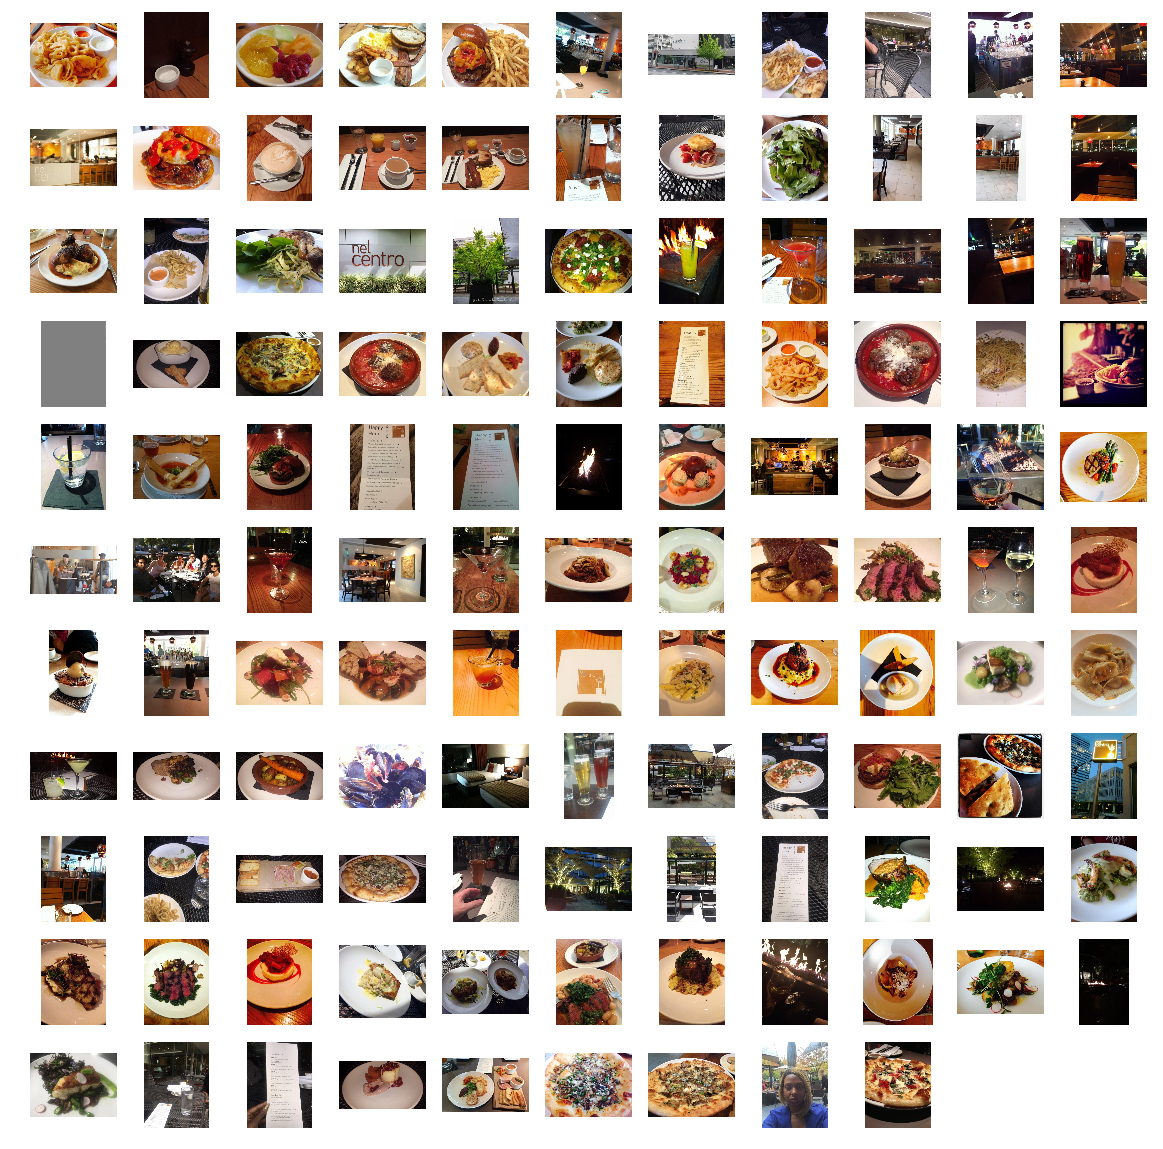

In [162]:
print(business_id)
print(result_mean.loc[business_id])
print(df_sorted_pred_with_business_id)

import math
imgs = [mpimg.imread(picture) for picture in pictures]
n = math.ceil(math.sqrt(len(imgs)))

fig = plt.figure(figsize=(20,20))

i = 1
for img in imgs:
  a=fig.add_subplot(n,n,i)
  plt.axis('off') 
  plt.imshow(img)
  i += 1


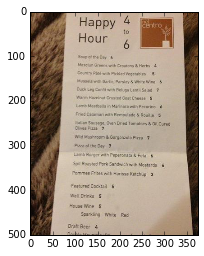

In [148]:
plt.imshow(imgs[18])

In [119]:
imshow(solver.net.blobs['data'].data[:8, 0].transpose(1, 0, 2).reshape(28, 8*28), cmap='gray')

['./train_photos/qhtx52779.jpg',
 './train_photos/sajv65603.jpg',
 './train_photos/bewx312193.jpg',
 './train_photos/qqcz427143.jpg',
 './train_photos/alat244833.jpg',
 './train_photos/qoah101916.jpg',
 './train_photos/iuav306967.jpg',
 './train_photos/bkxv331031.jpg',
 './train_photos/hczl20862.jpg',
 './train_photos/czdv151938.jpg',
 './train_photos/mgwr83528.jpg',
 './train_photos/vhct7226.jpg',
 './train_photos/eshu174670.jpg',
 './train_photos/nhcn364269.jpg',
 './train_photos/ibcm123190.jpg',
 './train_photos/pxmf368090.jpg',
 './train_photos/xdal268310.jpg',
 './train_photos/vqap17569.jpg',
 './train_photos/hntv81586.jpg',
 './train_photos/bdos342314.jpg',
 './train_photos/juce263715.jpg',
 './train_photos/guje278652.jpg',
 './train_photos/rgvo154804.jpg',
 './train_photos/vpzd215970.jpg',
 './train_photos/kuyc201272.jpg',
 './train_photos/alsw232564.jpg',
 './train_photos/nfop350511.jpg',
 './train_photos/ttxp320535.jpg',
 './train_photos/tvvh91756.jpg',
 './train_photos/htzp20

In [ ]:
pred[np.where(business_indices)][2]

In [ ]:
business_labels_true = map(lambda x: labels[int(x)], train.ix[business_id]['labels'].split())

#print(business_labels_pred)
print(business_labels_true)


In [ ]:
picture = pictures[3]
print(picture)
import cv2
%matplotlib inline
from matplotlib import pyplot as plt

img = cv2.cvtColor(cv2.imread(picture), cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [ ]:
# LogisticRegression, PassiveAggressiveClassifier or SGDClassifier
#from sklearn import svm
#clf = svm.LinearSVC()
#clf.fit(X[:100000], y.iloc[:100000,1])

In [ ]:
#clf = svm.SVC(decision_function_shape='ovo')
#clf.fit(X, y.iloc[:,1]) 
#dec = clf.decision_function([[1]])
#dec.shape[1]